# Meat Quality Assesment 

### Contents
#### 1. [Import Data & Packages](#Import-Data-&-Packages)
#### 2. [Data Loading and Augmentation](#Data-Loading-and-Augmentation)
#### 3. [Define Model](#Define-Model)
#### 4. [Training](#Training)
#### 5. [Test Cases](#Test-Cases)

# Import Data & Packages

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = pathlib.Path("../input/meat-quality-assessment-based-on-deep-learning/")
paths = list(data_dir.glob('*/*.jpg'))
def load_paths(path):
    path = path.absolute().as_posix()
    if "Fresh" in path:return str(path),1
    else:return path,0
ds = pd.DataFrame(map(load_paths,paths),columns =['Path','Fresh']).sample(frac=1).reset_index(drop=True)

# Keeping Out 16 images to test Later
ds = ds[:-16]
test = ds[-16:]

In [3]:
ds.head()

,Path,Fresh
0,/kaggle/working/../input/meat-quality-assessme...,1
1,/kaggle/working/../input/meat-quality-assessme...,1
2,/kaggle/working/../input/meat-quality-assessme...,1
3,/kaggle/working/../input/meat-quality-assessme...,0
4,/kaggle/working/../input/meat-quality-assessme...,0


<AxesSubplot:>

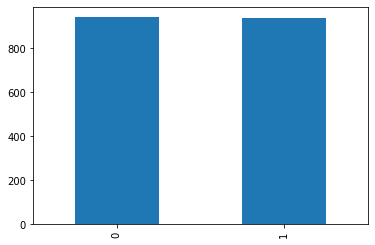

In [4]:
ds['Fresh'].value_counts().plot.bar()

# Data Loading and Augmentation

In [5]:
def load_img(path,fresh):
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.vgg19.preprocess_input(img)
    return img,fresh

def load_test_img(path):
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.vgg19.preprocess_input(img)
    return img

In [6]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:image = tf.image.transpose(image)
    if p_rotate > .75:image = tf.image.rot90(image, k=3) 
    elif p_rotate > .5:image = tf.image.rot90(image, k=2) 
    elif p_rotate > .25:image = tf.image.rot90(image, k=1) 

    if p_pixel_1 >= .4:image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:image = tf.image.random_brightness(image, max_delta=.1)

    if p_crop > .7:
        if p_crop > .9:image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:image = tf.image.central_crop(image, central_fraction=.8)
        else:image = tf.image.central_crop(image, central_fraction=.9)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(224*.8),224, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    
    image = tf.image.resize(image, [224,224])
    return image,label

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((ds.Path.values,ds.Fresh.values))

In [8]:
train_ds = dataset.take(int(0.8*len(ds)))
val_ds = dataset.skip(int(0.2*len(ds)))
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(load_img,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.repeat(4).map(data_augment,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(32).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(load_img,num_parallel_calls=AUTOTUNE).batch(32).prefetch(buffer_size=AUTOTUNE)

# Define Model

In [9]:
base_model = keras.applications.VGG19(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(2, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

80142336/80134624 [==============================] - 0s 0us/step


# Training

In [10]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history = model.fit(train_ds, epochs=5, validation_data=val_ds,verbose=1)

Epoch 1/5
188/188 [==============================] - 78s 397ms/step - loss: 1.3795 - accuracy: 0.6125 - val_loss: 0.1923 - val_accuracy: 0.9082
Epoch 2/5
188/188 [==============================] - 73s 387ms/step - loss: 0.2659 - accuracy: 0.8918 - val_loss: 0.1368 - val_accuracy: 0.9461
Epoch 3/5
188/188 [==============================] - 72s 381ms/step - loss: 0.2023 - accuracy: 0.9144 - val_loss: 0.1220 - val_accuracy: 0.9495
Epoch 4/5
188/188 [==============================] - 76s 405ms/step - loss: 0.1639 - accuracy: 0.9317 - val_loss: 0.0908 - val_accuracy: 0.9674
Epoch 5/5
188/188 [==============================] - 75s 399ms/step - loss: 0.1475 - accuracy: 0.9361 - val_loss: 0.0806 - val_accuracy: 0.9727


In [11]:
model.save("model.h5")

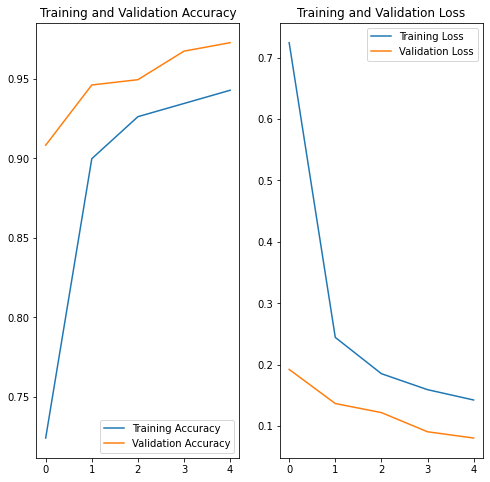

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test Cases

**Below Image's titles show the value predicted by the Classifier<br>
And the Font Color show the correctness of value<br>**
* **Green** [Correct Prediction]<br>
* **Red** [Incorrect Prediction]<br>

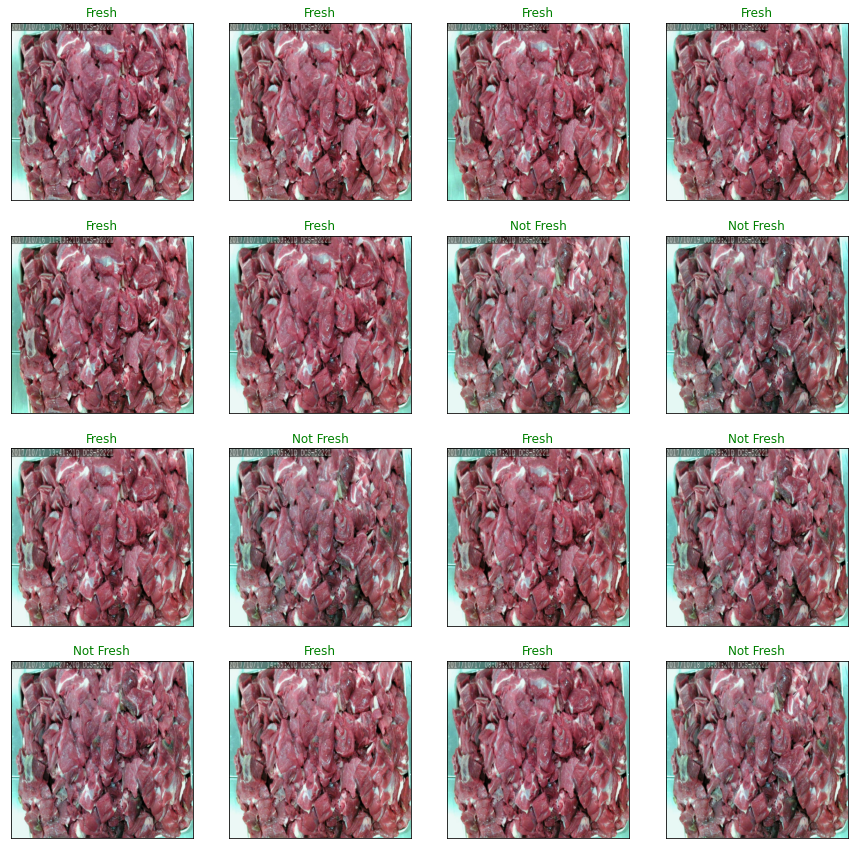

In [13]:
test_ds = tf.data.Dataset.from_tensor_slices((test.Path.values))
test_ds = test_ds.map(load_test_img).batch(3)
prediction = model.predict(test_ds)

plt.figure(figsize=(15,15))
i=0
for index,row in test.iterrows():
    img = tf.io.decode_jpeg(tf.io.read_file(row['Path']),channels=3)
    plt.subplot(4,4,i+1)
    plt.imshow(img.numpy().astype("uint8"),aspect='auto')
    if prediction[i][0]>prediction[i][1]:
        if row['Fresh']==0:plt.title("Not Fresh", color="green")
        else:plt.title("Not Fresh", color="red")
    else:
        if row['Fresh']==0:plt.title("Fresh", color="red")
        else:plt.title("Fresh", color="green")
    plt.xticks([]), plt.yticks([])
    i+=1    

plt.show()    

## We can see that the model classifies all of the images correctly, with high confidence.